In [1]:
import os
import sys

import math
from datetime import timezone, datetime

import joblib
import matplotlib.pyplot as plt
import mplfinance as mpf
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [2]:
# TimescaleDB用のユーティリティライブラリの設定
import sys
sys.path.append('..')
from timescaledb_util import TimeScaleDBUtil

_pg_config = {
        'user': os.environ['POSTGRES_USER'],
        'password': os.environ['POSTGRES_PASSWORD'],
        'host': os.environ['POSTGRES_HOST'],
        'port': os.environ['POSTGRES_PORT'],
        'database': os.environ['POSTGRES_DATABASE']
    }
    
_dbutil = TimeScaleDBUtil(user = _pg_config['user'], password = _pg_config['password'], host = _pg_config['host'], port = _pg_config['port'], database = _pg_config['database'])

In [3]:
_sql = f"SELECT * FROM \"ftx_btc-perp_dollar_cumsum_daily\" ORDER BY time ASC"
df = _dbutil.read_sql_query(sql = _sql)
df = df.set_index("time")    
df

,dollar_cumsum,buy_dollar_cumsum,sell_dollar_cumsum
time,,,
2019-03-05 00:00:00+00:00,4.075947e+02,3.889510e+02,1.864375e+01
2019-03-07 00:00:00+00:00,1.401854e+05,7.524169e+04,6.494369e+04
2019-03-08 00:00:00+00:00,2.036252e+05,1.386777e+05,6.494749e+04
2019-03-09 00:00:00+00:00,4.182689e+05,1.596371e+05,2.586319e+05
2019-03-10 00:00:00+00:00,1.286863e+06,6.546460e+05,6.322169e+05
...,...,...,...
2022-02-06 00:00:00+00:00,1.624662e+12,8.052507e+11,8.194116e+11
2022-02-07 00:00:00+00:00,1.629155e+12,8.075452e+11,8.216095e+11
2022-02-08 00:00:00+00:00,1.634747e+12,8.103896e+11,8.243574e+11


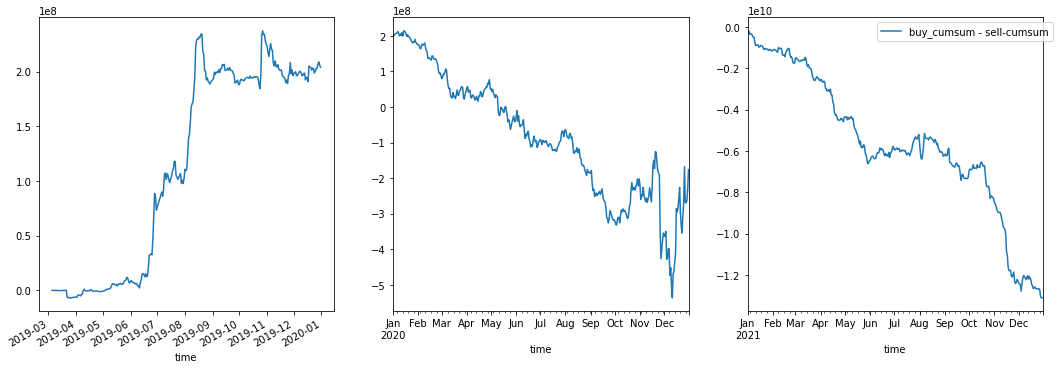

In [4]:
plt.figure(figsize=(18,6))
ax = plt.subplot(131)
#df['dollar_cumsum'].plot(label='dollar_cumsum', ax=ax)
(df.loc[df.index < '2020-01-01', 'buy_dollar_cumsum'] - df.loc[df.index < '2020-01-01', 'sell_dollar_cumsum']).plot(label='buy_cumsum - sell-cumsum', ax=ax)
ax = plt.subplot(132)
(df.loc[(df.index >= '2020-01-01') & (df.index < '2021-01-01'), 'buy_dollar_cumsum'] - df.loc[(df.index >= '2020-01-01') & (df.index < '2021-01-01'), 'sell_dollar_cumsum']).plot(label='buy_cumsum - sell-cumsum', ax=ax)
ax = plt.subplot(133)
(df.loc[(df.index >= '2021-01-01') & (df.index < '2022-01-01'), 'buy_dollar_cumsum'] - df.loc[(df.index >= '2021-01-01') & (df.index < '2022-01-01'), 'sell_dollar_cumsum']).plot(label='buy_cumsum - sell-cumsum', ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()